In [3]:
from scipy.io.wavfile import read
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import numpy as np
import cython
import math
from scipy.io.wavfile import write, read
from scipy.fftpack import fft, ifft
from scipy.signal import triang
from scipy.signal import get_window
import copy
import librosa
from scipy.stats import skew
import librosa.display

In [60]:
y, sr = librosa.load("for_experiment.wav")

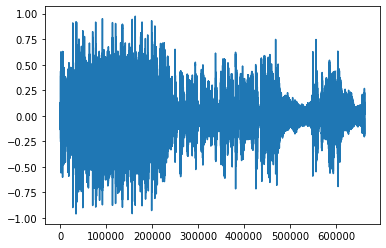

In [61]:
plt.plot(y)

In [88]:
#Define certain variables

fftl = 2048
hopl =250
winl = 1000
wintype = 'blackmanharris'

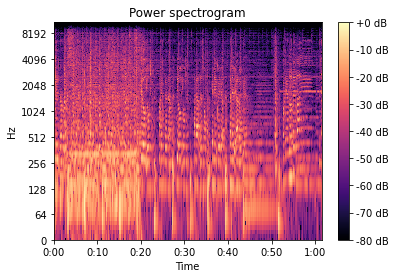

In [112]:
#making a power spectogram
S = np.abs(librosa.stft(y=y,n_fft=fftl, hop_length=hopl, win_length=winl, window=wintype))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)

ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

### 1. MFCC

In [81]:
mfccs = librosa.feature.mfcc(y=y, sr=sr,n_fft=fftl, hop_length=hopl, win_length=winl, window=wintype) 
mfccs.shape

(20, 2648)

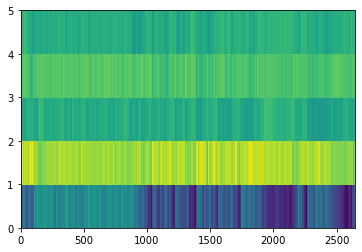

In [83]:
plt.pcolormesh(mfccs[0:5,])

In [84]:
#collecting mfcc features
mf_features = mfccs[:5,]

# mean, variance and skewness of first 5 components
features = np.concatenate((mf_features.mean(axis=1),mf_features.var(axis=1),skew(mf_features,axis=1)))
features

array([-1.69009216e+02,  1.15409645e+02, -1.77943573e+01,  4.01894608e+01,
       -1.03748798e+01,  5.62675928e+03,  5.70477417e+02,  3.78532471e+02,
        2.06879532e+02,  2.43164490e+02, -9.34692174e-02,  1.41157657e-01,
       -1.70934089e-02, -3.53556782e-01, -5.73543191e-01], dtype=float32)

### 2. Centroid

In [89]:
centroid = librosa.feature.spectral_centroid(y=y, sr=sr,n_fft=fftl, hop_length=hopl, win_length=winl, window=wintype)

array([[1999.28747446, 1925.68409777, 1889.55079071, ..., 2432.72522481,
        2368.00280145, 2488.38856622]])

In [94]:
centroid=np.reshape(centroid, centroid.shape[1])

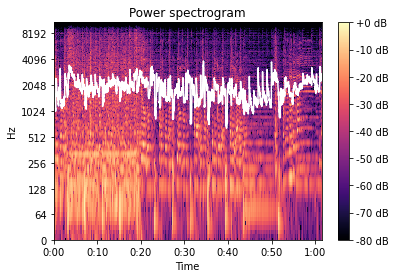

In [111]:
times = librosa.times_like(centroid)
S = np.abs(librosa.stft(y=y,n_fft=fftl, hop_length=hopl, win_length=winl, window=wintype))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.plot(times, centroid.T, label='Spectral centroid', color='w')
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

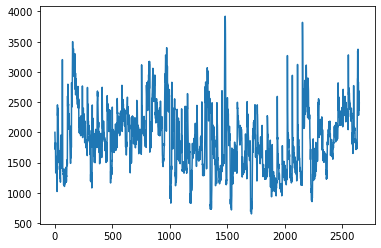

In [95]:
plt.plot(centroid)

In [97]:
centroid.var()

258808.92394300774

In [104]:
# adding centroid mean and centroid variance as features
features = np.concatenate((features,np.array([centroid.mean(),centroid.var()])))

In [105]:
features

array([-1.69009216e+02,  1.15409645e+02, -1.77943573e+01,  4.01894608e+01,
       -1.03748798e+01,  5.62675928e+03,  5.70477417e+02,  3.78532471e+02,
        2.06879532e+02,  2.43164490e+02, -9.34692174e-02,  1.41157657e-01,
       -1.70934089e-02, -3.53556782e-01, -5.73543191e-01,  1.87862859e+03,
        2.58808924e+05])

### 3. Spectral Roll-off

In [113]:
rollof= librosa.feature.spectral_rolloff(y=y, sr=sr,n_fft=fftl, hop_length=hopl, win_length=winl, window=wintype)

In [117]:
rollof=np.reshape(rollof, rollof.shape[1])
rollof.shape

(2648,)

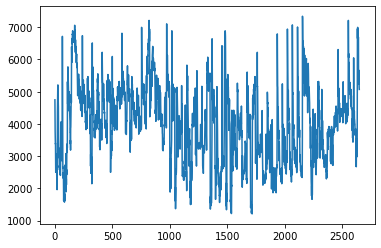

In [118]:
plt.plot(rollof)

[Text(0.5, 1.0, 'log Power spectrogram and Rolloff (0.85)')]

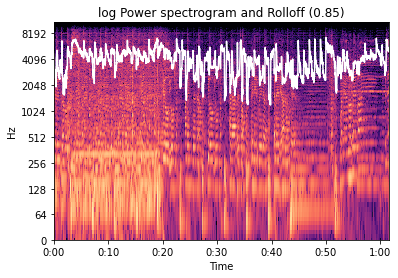

In [122]:
import matplotlib.pyplot as plt
times=librosa.times_like(rollof)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, rollof, label='Roll-off frequency (0.85)',color='w')
ax.set(title='log Power spectrogram and Rolloff (0.85)')

In [123]:
#mean and variance of rolloff is added
features = np.concatenate((features,np.array([rollof.mean(),rollof.var()])))
features

array([-1.69009216e+02,  1.15409645e+02, -1.77943573e+01,  4.01894608e+01,
       -1.03748798e+01,  5.62675928e+03,  5.70477417e+02,  3.78532471e+02,
        2.06879532e+02,  2.43164490e+02, -9.34692174e-02,  1.41157657e-01,
       -1.70934089e-02, -3.53556782e-01, -5.73543191e-01,  1.87862859e+03,
        2.58808924e+05,  3.99860523e+03,  1.39968697e+06])

### 4. RMS Energy for low energy feature

In [131]:
energyrms=librosa.feature.rms(y=y, hop_length=hopl)
energyrms.shape

(1, 2648)

In [132]:
energyrms=np.reshape(energyrms, energyrms.shape[1])
energyrms.shape

(2648,)

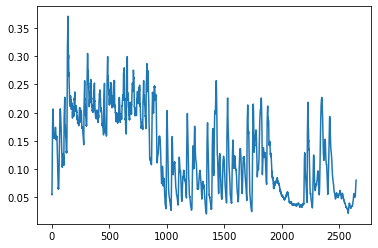

In [146]:
plt.plot(energyrms)

In [139]:
# % of frames that have energy levels lower than the mean energy levels
low_energy=sum(energyrms<energyrms.mean())/len(energyrms)

In [140]:
# add low energy features
features = np.concatenate((features,np.array([low_energy])))
features

array([-1.69009216e+02,  1.15409645e+02, -1.77943573e+01,  4.01894608e+01,
       -1.03748798e+01,  5.62675928e+03,  5.70477417e+02,  3.78532471e+02,
        2.06879532e+02,  2.43164490e+02, -9.34692174e-02,  1.41157657e-01,
       -1.70934089e-02, -3.53556782e-01, -5.73543191e-01,  1.87862859e+03,
        2.58808924e+05,  3.99860523e+03,  1.39968697e+06,  5.46072508e-01])

### 4. Zero crossings

In [143]:
num_zerocross=sum(librosa.zero_crossings(y))
num_zerocross

59810

In [144]:
features = np.concatenate((features,np.array([num_zerocross])))
features

array([-1.69009216e+02,  1.15409645e+02, -1.77943573e+01,  4.01894608e+01,
       -1.03748798e+01,  5.62675928e+03,  5.70477417e+02,  3.78532471e+02,
        2.06879532e+02,  2.43164490e+02, -9.34692174e-02,  1.41157657e-01,
       -1.70934089e-02, -3.53556782e-01, -5.73543191e-01,  1.87862859e+03,
        2.58808924e+05,  3.99860523e+03,  1.39968697e+06,  5.46072508e-01,
        5.98100000e+04])

### 5. Croma / Pitch features

In [159]:
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

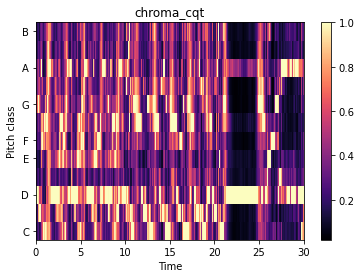

In [160]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
img = librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
ax.set(title='chroma_cqt')
fig.colorbar(img, ax=ax)

In [163]:
pitch_class = chroma_cq.mean(axis=1)

In [164]:
features = np.concatenate((features,pitch_class))
features

array([-1.69009216e+02,  1.15409645e+02, -1.77943573e+01,  4.01894608e+01,
       -1.03748798e+01,  5.62675928e+03,  5.70477417e+02,  3.78532471e+02,
        2.06879532e+02,  2.43164490e+02, -9.34692174e-02,  1.41157657e-01,
       -1.70934089e-02, -3.53556782e-01, -5.73543191e-01,  1.87862859e+03,
        2.58808924e+05,  3.99860523e+03,  1.39968697e+06,  5.46072508e-01,
        5.98100000e+04,  4.41602618e-01,  4.76759017e-01,  7.08077312e-01,
        3.13685864e-01,  3.74551892e-01,  4.06817645e-01,  4.72964823e-01,
        4.53643918e-01,  4.15040821e-01,  5.06794870e-01,  3.19951683e-01,
        3.45000088e-01])

### 6. Rhythmic/Beat features

In [189]:
hop_length = hopl
# Estimate a static tempo
oenv = librosa.onset.onset_strength(y, sr=sr,hop_length=hop_length )
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)



In [190]:
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                           hop_length=hop_length)[0]

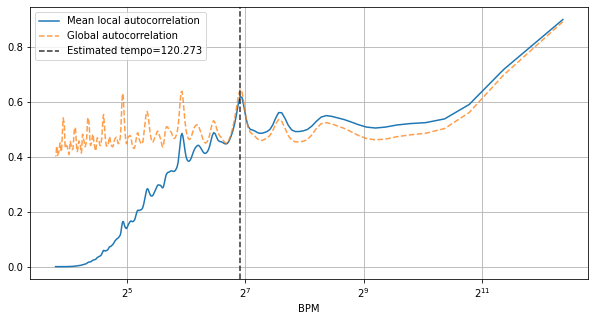

In [210]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))
freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
ax.semilogx(freqs[1:], np.mean(tempogram[1:], axis=1),
             label='Mean local autocorrelation', base=2)
ax.semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75,
             label='Global autocorrelation', base=2)
ax.axvline(tempo, color='black', linestyle='--', alpha=.8,
            label='Estimated tempo={:g}'.format(tempo))
ax.legend(frameon=True)
ax.set(xlabel='BPM')
ax.grid(True)

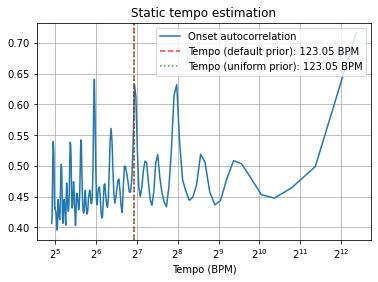

In [180]:
# Convert to scalar
tempo = tempo.item()
utempo = utempo.item()
# Compute 2-second windowed autocorrelation
hop_length = hopl
ac = librosa.autocorrelate(onset_env, 2 * sr // hop_length)
freqs = librosa.tempo_frequencies(len(ac), sr=sr,
                                  hop_length=hop_length)
# Plot on a BPM axis.  We skip the first (0-lag) bin.
fig, ax = plt.subplots()
ax.semilogx(freqs[1:], librosa.util.normalize(ac)[1:],
             label='Onset autocorrelation', base=2)
ax.axvline(tempo, 0, 1, alpha=0.75, linestyle='--', color='r',
            label='Tempo (default prior): {:.2f} BPM'.format(tempo))
ax.axvline(utempo, 0, 1, alpha=0.75, linestyle=':', color='g',
            label='Tempo (uniform prior): {:.2f} BPM'.format(utempo))
ax.set(xlabel='Tempo (BPM)', title='Static tempo estimation')
ax.grid(True)
ax.legend()

In [185]:
librosa.util.normalize(ac)[3:].max()

0.6405468636361802

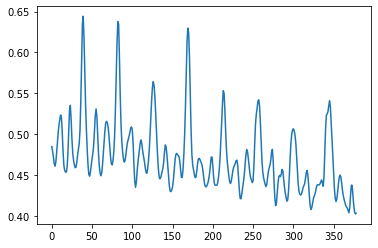

In [213]:
plt.plot(ac_global[5:])

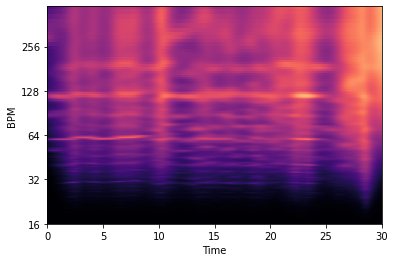

In [201]:
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma'
                        )

In [223]:
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
tempo

array([95.703125])

In [224]:
features_rhythm = np.array([np.mean(tempogram[5:],axis=1).max(),np.mean(tempogram[5:],axis=1).sum(),tempo.item()])
features_rhythm

array([ 0.61839604, 67.13354573, 95.703125  ])

In [225]:
features = np.concatenate((features,features_rhythm))
features

array([-1.69009216e+02,  1.15409645e+02, -1.77943573e+01,  4.01894608e+01,
       -1.03748798e+01,  5.62675928e+03,  5.70477417e+02,  3.78532471e+02,
        2.06879532e+02,  2.43164490e+02, -9.34692174e-02,  1.41157657e-01,
       -1.70934089e-02, -3.53556782e-01, -5.73543191e-01,  1.87862859e+03,
        2.58808924e+05,  3.99860523e+03,  1.39968697e+06,  5.46072508e-01,
        5.98100000e+04,  4.41602618e-01,  4.76759017e-01,  7.08077312e-01,
        3.13685864e-01,  3.74551892e-01,  4.06817645e-01,  4.72964823e-01,
        4.53643918e-01,  4.15040821e-01,  5.06794870e-01,  3.19951683e-01,
        3.45000088e-01,  6.18396037e-01,  6.71335457e+01,  9.57031250e+01])

In [226]:
features.shape

(36,)

In [230]:
columns = ["mfcc_mean1","mfcc_mean2","mfcc_mean3","mfcc_mean4","mfcc_mean5","mfcc_var1","mfcc_var2","mfcc_var3","mfcc_var4","mfcc_var5","mfcc_skew1","mfcc_skew2","mfcc_skew3","mfcc_skew4","mfcc_skew5","centroid_mean","centroid_var","rolloff_mean","rolloff_var","low_energy","zero_cross","pitch1","pitch2","pitch3""pitch4","pitch5","pitch6","pitch7","pitch8","pitch9","pitch10","pitch11","pitch12","tempo_max","tempo_sum","tempo_beat"]

In [231]:
len(columns)

35